## import necessary packages

In [2]:
import glob
from Algonauts2021_devkit.feature_extraction.alexnet import *
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
from tqdm import tqdm
from torchvision import transforms as trn
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
from decord import VideoReader
from decord import cpu

## Load alexnet, video, fMRI data

In [3]:
seed = 42
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

def load_alexnet(model_checkpoints):
    """This function initializes an Alexnet and load
    its weights from a pretrained model
    ----------
    model_checkpoints : str
        model checkpoints location.

    Returns
    -------
    model
        pytorch model of alexnet

    """


    model = alexnet()
    model_file = model_checkpoints
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    model_dict =["conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias", "conv3.0.weight", "conv3.0.bias", "conv4.0.weight", "conv4.0.bias", "conv5.0.weight", "conv5.0.bias", "fc6.1.weight", "fc6.1.bias", "fc7.1.weight", "fc7.1.bias", "fc8.1.weight", "fc8.1.bias"]
    state_dict={}
    i=0
    for k,v in checkpoint.items():
        state_dict[model_dict[i]] =  v
        i+=1

    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    return model


def sample_video_from_mp4(file, num_frames=16):
    """This function takes a mp4 video file as input and returns
    a list of uniformly sampled frames (PIL Image).
    Parameters
    ----------
    file : str
        path to mp4 video file
    num_frames : int
        how many frames to select using uniform frame sampling.
    Returns
    -------
    images: list of PIL Images
    num_frames: int
        number of frames extracted
    """
    images = list()
    vr = VideoReader(file, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
    for seg_ind in indices:
        images.append(Image.fromarray(vr[seg_ind].asnumpy()))
    return images,num_frames

def get_activations_and_save(model, video_list, activations_dir):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    video_list : list
        the list contains path to all videos.
    activations_dir : str
        save path for extracted features.
    """

    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    for video_file in tqdm(video_list):
        vid,num_frames = sample_video_from_mp4(video_file)
        video_file_name = os.path.split(video_file)[-1].split(".")[0]
        activations = []
        for frame,img in enumerate(vid):
            input_img = V(resize_normalize(img).unsqueeze(0))
            if torch.cuda.is_available():
                input_img=input_img.cuda()
            x = model.forward(input_img)
            for i,feat in enumerate(x):
                if frame==0:
                    activations.append(feat.data.cpu().numpy().ravel())
                else:
                    activations[i] =  activations[i] + feat.data.cpu().numpy().ravel()
        for layer in range(len(activations)):
            save_path = os.path.join(activations_dir, video_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            avg_layer_activation = activations[layer]/float(num_frames)
            np.save(save_path,avg_layer_activation)


## PCA analysis

In [ ]:
def do_PCA_and_save(activations_dir, save_dir):
    """This function preprocesses Neural Network features using PCA (because of too much output) and save the results
    in  a specified directory
.

    Parameters
    ----------
    activations_dir : str
        save path for extracted features.
    save_dir : str
        save path for extracted PCA features.

    """

    layers = ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8']
    n_components = 100
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for layer in tqdm(layers):
        activations_file_list = glob.glob(activations_dir +'/*'+layer+'.npy')
        activations_file_list.sort()
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp
        x_train = x[:1000,:]
        x_test = x[1000:,:]

        start_time = time.time()
        x_test = StandardScaler().fit_transform(x_test)
        x_train = StandardScaler().fit_transform(x_train)
        ipca = PCA(n_components=n_components,random_state=seed)
        ipca.fit(x_train)

        x_train = ipca.transform(x_train)
        x_test = ipca.transform(x_test)
        train_save_path = os.path.join(save_dir,"train_"+layer)
        test_save_path = os.path.join(save_dir,"test_"+layer)
        np.save(train_save_path,x_train)
        np.save(test_save_path,x_test)
        

## RUN!

In [18]:
# parser = argparse.ArgumentParser(description='Feature Extraction from Alexnet and preprocessing using PCA')
# parser.add_argument('-vdir','--video_data_dir', help='video data directory',default = './AlgonautsVideos268_All_30fpsmax/', type=str)
# parser.add_argument('-sdir','--save_dir', help='saves processed features',default = './alexnet/', type=str)
# args = vars(parser.parse_args())

# set the directory
save_dir='./alexnet/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

video_dir = './AlgonautsVideos268_All_30fpsmax/'
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()
print('Total Number of Videos: ', len(video_list))

# load Alexnet
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
checkpoint_path = "./alexnet.pth"
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, "./alexnet.pth")
model = load_alexnet(checkpoint_path)

# get and save activations of each layer of AlexNet
activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, video_list, activations_dir)

# preprocessing using PCA and save
pca_dir = os.path.join(save_dir, 'pca_100')
print("-------------performing  PCA----------------------------")
do_PCA_and_save(activations_dir, pca_dir)

Total Number of Videos:  1102
-------------Saving activations ----------------------------


  0%|                                                                                         | 0/1102 [00:00<?, ?it/s]C:\Users\Dasom\AppData\Local\Temp/ipykernel_22180/426207514.py:60: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
100%|██████████████████████████████████████████████████████████████████████████████| 1102/1102 [09:03<00:00,  2.03it/s]


-------------performing  PCA----------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:43<00:00, 12.90s/it]


## Modeling

In [63]:
import numpy as np
import os
import glob
import random
import argparse
import itertools
import nibabel as nib
from nilearn import plotting
from tqdm import tqdm
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import torch
import time
import pickle
from tqdm import tqdm
from Algonauts2021_devkit.utils.ols import vectorized_correlation,OLS_pytorch
from Algonauts2021_devkit.utils.helper import save_dict,load_dict, saveasnii

#### * Get layer activation and fMRI data

In [5]:
def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.

    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,

    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos

    """

    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.

    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.

    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI

    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def predict_fmri_fast(train_activations, test_activations, train_fmri,use_gpu=False):
    """This function fits a linear regressor using train_activations and train_fmri,
    then returns the predicted fmri_pred_test using the fitted weights and
    test_activations.

    Parameters
    ----------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos.
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    train_fmri : np.array
        matrix of dimensions #train_vids x  #voxels
        containing fMRI responses to train videos
    use_gpu : bool
        Description of parameter `use_gpu`.

    Returns
    -------
    fmri_pred_test: np.array
        matrix of dimensions #test_vids x  #voxels
        containing predicted fMRI responses to test videos .

    """

    reg = OLS_pytorch(use_gpu)
    reg.fit(train_activations,train_fmri.T)
    fmri_pred_test = reg.predict(test_activations)
    return fmri_pred_test

#### * Calculating correlation

In [9]:
# parser = argparse.ArgumentParser(description='Encoding model analysis for Algonauts 2021')
# parser.add_argument('-rd','--result_dir', help='saves predicted fMRI activity',default = './results', type=str)
# parser.add_argument('-ad','--activation_dir',help='directory containing DNN activations',default = './alexnet/', type=str)
# parser.add_argument('-model','--model',help='model name under which predicted fMRI activity will be saved', default = 'alexnet_devkit', type=str)
# parser.add_argument('-l','--layer',help='layer from which activations will be used to train and predict fMRI activity', default = 'layer_5', type=str)
# parser.add_argument('-sub','--sub',help='subject number from which real fMRI data will be used', default = 'sub04', type=str)
# parser.add_argument('-r','--roi',help='brain region, from which real fMRI data will be used', default = 'EBA', type=str)
# parser.add_argument('-m','--mode',help='test or val, val returns mean correlation by using 10% of training data for validation', default = 'val', type=str)
# parser.add_argument('-fd','--fmri_dir',help='directory containing fMRI activity', default = './participants_data_v2021', type=str)
# parser.add_argument('-v','--visualize',help='visualize whole brain results in MNI space or not', default = True, type=bool)
# parser.add_argument('-b', '--batch_size',help=' number of voxel to fit at one time in case of memory constraints', default = 1000, type=int)
# args = vars(parser.parse_args())


mode = 'val'
sub = 'sub01' # sub01 ~ sub10
ROI = 'FFA' # EBA, FFA, LOC, PPA, STS, V1, V2, V3, V4
model = 'Algonauts2021_devkit/'
layer = 'layer_6' # layer_1 ~ layer_8
visualize_results = True
batch_size = 1000 # number of voxel to fit at one time in case of memory constraints

if torch.cuda.is_available():
    use_gpu = True
else:
    use_gpu = False

if ROI == "WB":
    track = "full_track"
else:
    track = "mini_track"

activation_dir = './alexnet/pca_100'
fmri_dir = './participants_data_v2021'

sub_fmri_dir = os.path.join(fmri_dir, track, sub)
results_dir = './result'

print("ROi is : ", ROI)

train_activations,test_activations = get_activations(activation_dir, layer)
if track == "full_track":
    fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
else:
    fmri_train_all = get_fmri(sub_fmri_dir,ROI)
num_voxels = fmri_train_all.shape[1]
if mode == 'val':
    # Here as an example we use first 900 videos as training and rest of the videos as validation
    test_activations = train_activations[900:,:]
    train_activations = train_activations[:900,:]
    fmri_train = fmri_train_all[:900,:]
    fmri_test = fmri_train_all[900:,:]
    pred_fmri = np.zeros_like(fmri_test)
    pred_fmri_save_path = os.path.join(results_dir, ROI + '_val.npy')
else:
    fmri_train = fmri_train_all
    num_test_videos = 102
    pred_fmri = np.zeros((num_test_videos,num_voxels))
    pred_fmri_save_path = os.path.join(results_dir, ROI + '_test.npy')


print("number of voxels is ", num_voxels)
iter = 0
while iter < num_voxels-batch_size:
    pred_fmri[:,iter:iter+batch_size] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
    iter = iter+batch_size
    print((100*iter)//num_voxels," percent complete")
pred_fmri[:,iter:] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)

if mode == 'val':
    score = vectorized_correlation(fmri_test,pred_fmri)
    print("----------------------------------------------------------------------------")
    print("Mean correlation for ROI : ",ROI, "in ",sub, " is :", round(score.mean(), 3))

    # result visualization for whole brain (full_track)
    if track == "full_track" and visualize_results:
        visual_mask_3D = np.zeros((78,93,71))
        visual_mask_3D[voxel_mask==1]= score
        brain_mask = './Algonauts2021_devkit/example.nii'
        nii_save_path =  os.path.join(results_dir, ROI + '_val.nii')
        saveasnii(brain_mask,nii_save_path,visual_mask_3D)
        view = plotting.view_img_on_surf(nii_save_path, threshold=None, surf_mesh='fsaverage',\
                                        title = 'Correlation for sub' + sub, colorbar=False)
        view_save_path = os.path.join(results_dir,ROI + '_val.html')
        view.save_as_html(view_save_path)
        print("Results saved in this directory: ", results_dir)
        view.open_in_browser()


np.save(pred_fmri_save_path, pred_fmri)


print("----------------------------------------------------------------------------")
print("ROI done : ", ROI)

ROi is :  FFA
number of voxels is  68
----------------------------------------------------------------------------
Mean correlation for ROI :  FFA in  sub01  is : 0.215
----------------------------------------------------------------------------
ROI done :  FFA


In [87]:
if torch.cuda.is_available():
    use_gpu = True
else:
    use_gpu = False
    
mode = 'val'

model = 'Algonauts2021_devkit/'
visualize_results = True
batch_size = 1000 # number of voxel to fit at one time in case of memory constraints

activation_dir = './alexnet/pca_100'
fmri_dir = './participants_data_v2021'
results_dir = './result'

def calculate_correlation(mode, sub, ROI, layer, track = 'mini_track', visualize_results = False, save_results = False):
    if ROI == "WB":
        track = "full_track"
    else:
        track = "mini_track"
    sub_fmri_dir = os.path.join(fmri_dir, track, sub)
    train_activations,test_activations = get_activations(activation_dir, layer)
    if track == "full_track":
        fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
    else:
        fmri_train_all = get_fmri(sub_fmri_dir,ROI)
    num_voxels = fmri_train_all.shape[1]
    if mode == 'val':
        # Here as an example we use first 900 videos as training and rest of the videos as validation
        test_activations = train_activations[900:,:]
        train_activations = train_activations[:900,:]
        fmri_train = fmri_train_all[:900,:]
        fmri_test = fmri_train_all[900:,:]
        pred_fmri = np.zeros_like(fmri_test)
        pred_fmri_save_path = os.path.join(results_dir, ROI + '_val.npy')
    else:
        fmri_train = fmri_train_all
        num_test_videos = 102
        pred_fmri = np.zeros((num_test_videos,num_voxels))
        pred_fmri_save_path = os.path.join(results_dir, ROI + '_test.npy')

    iter = 0
    while iter < num_voxels-batch_size:
        pred_fmri[:,iter:iter+batch_size] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
        iter = iter+batch_size
#         print((100*iter)//num_voxels," percent complete")
    pred_fmri[:,iter:] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
    score = vectorized_correlation(fmri_test,pred_fmri)
    if track == "full_track" and save_results:
        visual_mask_3D = np.zeros((78,93,71))
        visual_mask_3D[voxel_mask==1]= score
        brain_mask = './Algonauts2021_devkit/example.nii'
        nii_save_path = os.path.join(results_dir, ROI + sub + layer + '_val.nii')
        saveasnii(brain_mask,nii_save_path,visual_mask_3D)
        if visualize_results:
            view = plotting.view_img_on_surf(nii_save_path, threshold=None, surf_mesh='fsaverage',\
                                            title = 'Correlation for ' + sub, colorbar=True, vmax=0.3)
            view_save_path = os.path.join(results_dir,ROI + sub + layer + '_val.html')
            view.save_as_html(view_save_path)
            print("Results saved in this directory: ", results_dir)
            view.open_in_browser()
    return score

def visualization(filename):
    nii_save_path = os.path.join(results_dir, filename)
    view = plotting.view_img_on_surf(nii_save_path, threshold=None, surf_mesh='fsaverage',\
                                        title = 'Whole subject', colorbar=True, vmax=0.3)
    view_save_path = os.path.join(results_dir,filename[:-3] + 'html')
    view.save_as_html(view_save_path)
    view.open_in_browser()

In [16]:
# sub = 'sub01' # sub01 ~ sub10
# ROI = 'FFA' # EBA, FFA, LOC, PPA, STS, V1, V2, V3, V4
# layer = 'layer_8' # layer_1 ~ layer_8
ROI_list = ['V1','V2','V3','V4','LOC','EBA','FFA','PPA','STS']
layer_list = ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8']
total_corr = []
for s in range(10):
    sub = 'sub%02d' % (s+1)
    sub_corr = []
    for roi in ROI_list:
        roi_corr = []
        for l in range(8):
            layer = 'layer_%d' % (l+1)
            corr = calculate_correlation(mode, sub, roi, layer)
            roi_corr.append(corr.mean())
        sub_corr.append(np.array(roi_corr))
    total_corr.append(np.array(sub_corr))
total_corr = np.array(total_corr)

#### * Plot correlation results

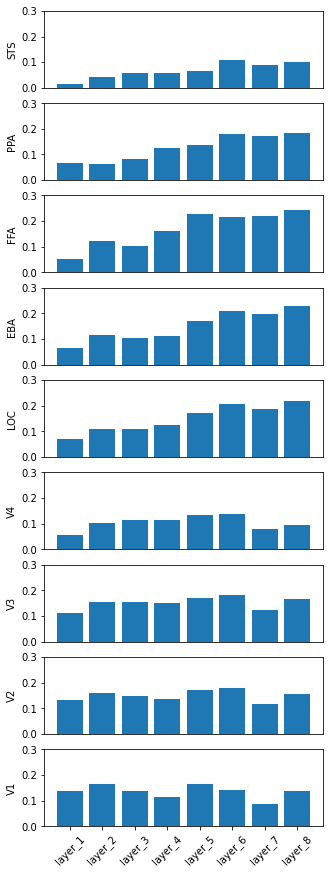

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=[5,15])
for i in range(9):
    plt.subplot(9,1,i+1)
    plt.bar(np.arange(8),np.mean(total_corr, axis=0).T[:,8-i])
    plt.ylim([0,0.3])
    plt.ylabel(ROI_list[8-i])
    if i == 8:
        plt.xticks(np.arange(8), layer_list, rotation=45)
    else:
        plt.xticks([])
    # plt.legend(ROI_list)

#### * Cortical mapping

In [ ]:
# sub = 'sub01' # sub01 ~ sub10
# ROI = 'FFA' # EBA, FFA, LOC, PPA, STS, V1, V2, V3, V4
# layer = 'layer_8' # layer_1 ~ layer_8
layer_list = ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8']
# total_corr2 = []
for s in range(10):
    sub = 'sub%02d' % (s+1)
#     sub_corr2 = []
    roi = 'WB'
    for l in range(8):
        layer = 'layer_%d' % (l+1)
        corr = calculate_correlation(mode, sub, roi, layer, save_results=True)
#         sub_corr2.append(corr)
#     total_corr2.append(np.array(sub_corr2))
# total_corr2 = np.array(total_corr2)

#### * Average subjects' map and visualize it

In [78]:
brain_mask = './Algonauts2021_devkit/example.nii'
fmri_data = []
for j in range(8):
    for i in range(10):
        data = nib.load('./result/WBsub%02dlayer_%d_val.nii' %(i+1, j+1)).get_fdata()
        fmri_data.append(data)
    score = np.mean(np.array(fmri_data), axis=0)
    nii_save_path = os.path.join(results_dir, 'WB_' + 'total_' + f'layer_{j+1}_' + 'val.nii')
    saveasnii(brain_mask,nii_save_path,score)
    visualization(f'WB_total_layer_{i+1}_val.nii')

(78, 93, 71)
